In [1]:
import numpy as np
from PIL import Image
import colorsys
import pylab

## Functions

In [2]:
def gaussian_weights(source, target, sigma):
    return np.exp(-(source - target)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def hue(source, target, amount):
    """Move the hue of source closer to the target, 
    assuming source and target angles between [-pi; pi],
    according to their distance
    """
    
    if amount != 0:
        sigma = np.pi
        x = np.cos(source) + amount * (np.cos(target) - np.cos(source)) * np.pi * gaussian_weights(np.cos(source), np.cos(target), sigma)
        y = np.sin(source) + amount * (np.sin(target) - np.sin(source)) * np.pi * gaussian_weights(np.sin(source), np.sin(target), sigma)

        return np.arctan2(y, x)
    
    else :
        return source

def normal2rad(theta):
    """Remap the hue channel to [-pi; pi] radians assuming source is in [0;1]"""
    
    # Rescale [0; 1] to [0; 2 pi]
    theta = theta * 2 * np.pi
    
    # Remap [pi; 2 pi] to [-pi; 0]
    negative = theta > np.pi # Boolean array : put 1 where theta > pi
    theta[negative] = - (2 * np.pi - theta[negative]) 
    
    return theta

def rad2normal(theta):
    """Remap the hue channel to [0; 1] assuming source is in [-pi; pi] radians"""
    
    # Remap [-pi; 0] to [0; 2 pi]
    negative = theta < 0 # Boolean array : put 1 where theta < 0
    theta[negative] = 2 * np.pi + theta[negative]
    
    # Rescale to [0;1]
    theta = theta / (2 * np.pi)
    
    return theta

## Masks

In [3]:
def highlights(pixels):
    """Build a progressive luminance mask between [0;1],
    assuming luminance in [0;1], as a gaussian function centered on 1"""
    
    sigma = 1/4.
    mask = gaussian_weights(pixels, 1, sigma)
    return mask

def midtones(pixels):
    """Build a progressive luminance mask between [0;1],
    assuming luminance in [0;1], as a gaussian function centered on 0.5"""
    
    sigma = 1/8.
    mask = gaussian_weights(pixels, 0.5, sigma)
    return mask

def shadows(pixels):
    """Build a progressive luminance mask between [0;1],
    assuming luminance in [0;1], as a gaussian function centered on 0"""
    
    sigma = 1/4.
    mask = gaussian_weights(pixels, 0, sigma)
    return mask

## Test the functions behavior on the whole range

In [5]:
theta = np.arange(0, 1, 0.001)

### Shift colors to red (0°)

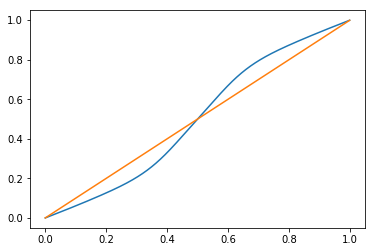

In [6]:
y = rad2normal(hue(normal2rad(theta), 0, 1))
pylab.plot(theta, y)
pylab.plot(theta, theta)

### Shift colors to cyan (180°)

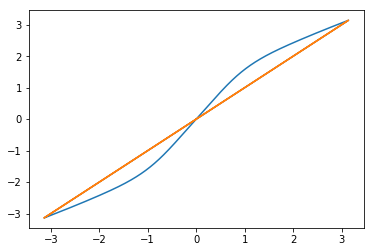

In [7]:
y = hue(normal2rad(theta), np.pi, 1)
pylab.plot(normal2rad(theta), y)
pylab.plot(normal2rad(theta), normal2rad(theta))

### Shift color to green-ish (90°)

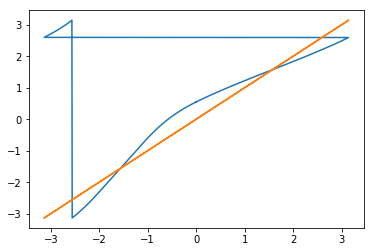

In [8]:
y = hue(normal2rad(theta), np.pi/2, 1)
pylab.plot(normal2rad(theta), y)
pylab.plot(normal2rad(theta), normal2rad(theta))

### Check the luma masks

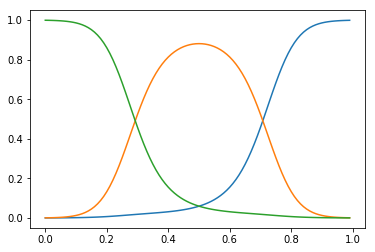

In [9]:
x = np.arange(0, 1, 0.01)
norm = highlights(x) + midtones(x) + shadows(x)
pylab.plot(x, highlights(x) / norm)
pylab.plot(x, midtones(x) / norm)
pylab.plot(x, shadows(x) / norm)

## Test the functions on a real image

In [10]:
# Load image
im = Image.open("../img/153412.jpg")

# Convert RGB image to HSL
r,g,b = im.split()
H = []
S = []
V = []    
for red, green, blue in zip(r.getdata(),g.getdata(),b.getdata()):
    h, s, v = colorsys.rgb_to_hsv(red/255.,green/255.,blue/255.)
    H.append(h)
    S.append(s)
    V.append(v)

# Convert to Numpy arrays
H = np.array(H)
V = np.array(V)

# Convert hue to radians
H = normal2rad(H)

In [14]:
# Build the masks
high = highlights(V)
mid = midtones(V)
low = shadows(V)
total = high + mid + low

In [20]:
# Adjust the main hue
H_bis = hue(H, np.pi, 0.5)

In [ ]:
# Adjust hue selectively for luminance zones 
H_bis = hue(H_bis, 0, 1) * high/total + hue(H_bis, np.pi / 6, 0.5) * mid/total + hue(H_bis, np.pi, 1) * low/total # Perform an teel/orange shift

In [ ]:
# Convert hue back to normal [0;1]
H_bis = rad2normal(H_bis)

# Convert back HSL image to RGB
rout = []
gout = []
bout = []  
for h, s, v in zip(H_bis, S, V):
    rd, gn, bl = colorsys.hsv_to_rgb(h, s, v)
    rout.append(rd * 255)
    gout.append(gn * 255)
    bout.append(bl * 255)

# Save image
r.putdata(rout)
g.putdata(gout)
b.putdata(bout)
newimg = Image.merge('RGB',(r,g,b))
newimg.save('153412-hue-shift.jpg')